# MNIST

## data

In [1]:
import qsvm.Qmapping as Q
import qsvm.data_function as df
import numpy as np
from qsvm.qsvm import Pca,QSVM

In [2]:
from scipy.io import loadmat
import random

f = open('./Datasets/mini.json', 'r') 
tg = json.load(f)
f.close()
traindata = np.array(tg['train']['data'])
trainlabels = np.array(tg['train']['label'])
testdata = np.array(tg['test']['data'])
testlabels = np.array(tg['test']['label'])


print(traindata.shape)
print(trainlabels.shape)
print(testdata.shape)
print(testlabels.shape)

(400, 784)
(400,)
(200, 784)
(200,)


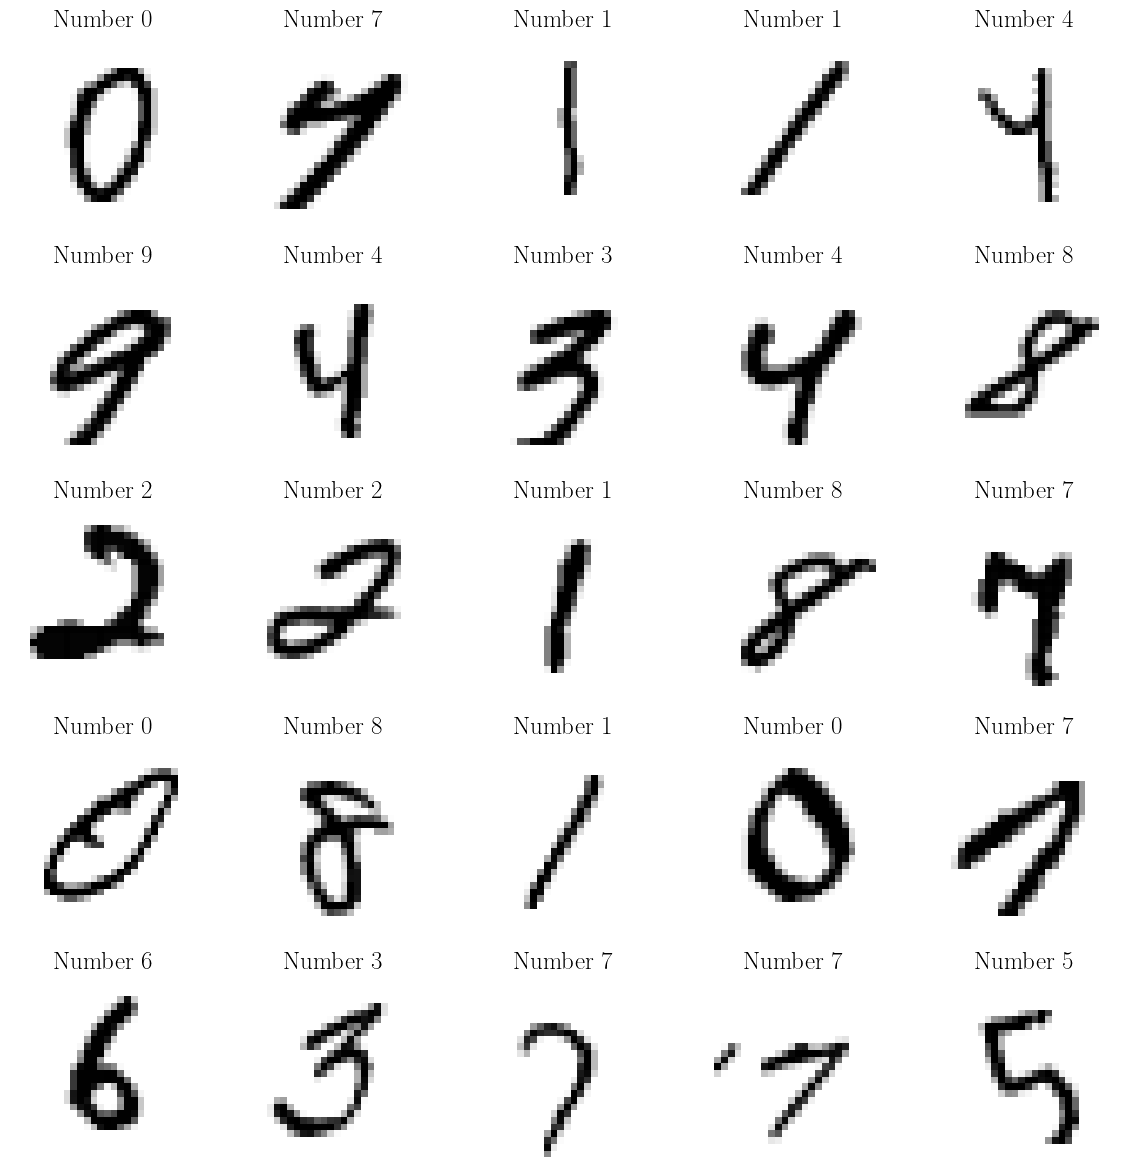

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, axs = plt.subplots(5, 5, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
  ax.imshow(traindata[i].reshape((28, 28)), cmap=cm.gray_r)
  ax.axis('off')
  ax.set_title('Number {}'.format(trainlabels[i]))

## Data pre-processing

In [4]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

### PCA

In [5]:
pca=Pca(PCA_n=10,StandardizeOrNot=False,sklearnPCA=True)

In [6]:
pca.fitting(traindata)
svm_tr_data=pca.transform(traindata)
svm_te_data=pca.transform(testdata)

# Renormalize each feature
svm_tr_data=pca.Renormalize_Each_Feature(svm_tr_data,Norm=np.pi/2,status="train")
svm_te_data=pca.Renormalize_Each_Feature(svm_te_data,Norm=np.pi/2)

## Construct Quantum Kernal

In [7]:
import time

In [8]:
qsvm=QSVM(task='svc')
qsvm.default_phys_sys()

In [9]:
error=[0.005,0.01,0.1]
start_time = time.time()
tr_kernel=qsvm.get_kernel(svm_tr_data,tier=1,method="digital", op="x",Error=error)
te_kernel=qsvm.get_kernel(svm_te_data,status="test",tier=1,method="digital", op="x",Error=error)
end_time=time.time()


KeyboardInterrupt



In [12]:
cost_time=end_time-start_time

In [13]:
print(cost_time)

12.913234949111938


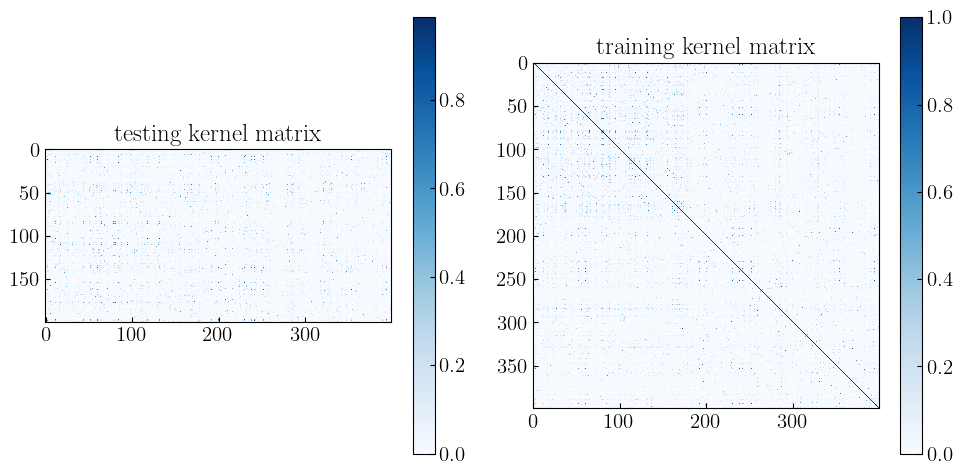

In [14]:
Q.show_kmatrix(train = tr_kernel , test = te_kernel,name = "")

## Supported Vector Machine

In [11]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import linear_kernel,rbf_kernel

### Linear kernel

In [16]:
_k_linear_tr = linear_kernel(svm_tr_data)
_k_linear_te = linear_kernel(svm_te_data,svm_tr_data)

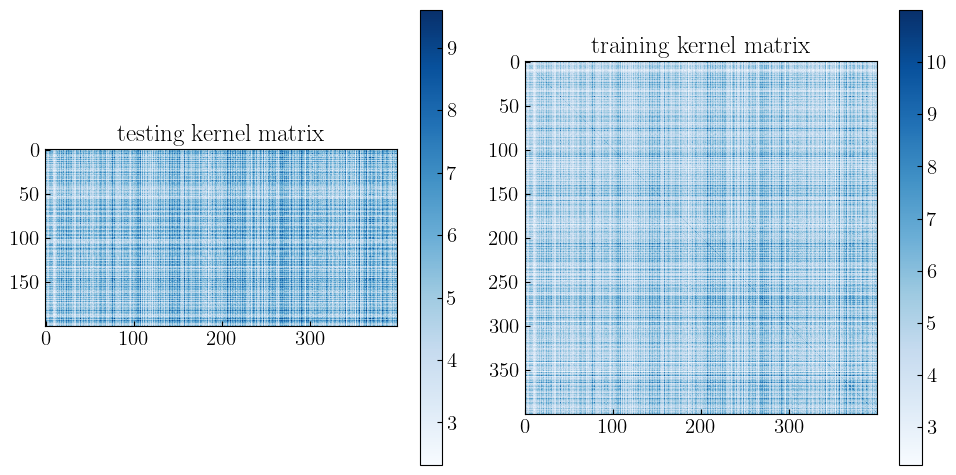

In [17]:
Q.show_kmatrix(train = _k_linear_tr , test = _k_linear_te,name = "")

In [18]:
clf = SVC(kernel="precomputed",C=1.0)
clf.fit(_k_linear_tr, trainlabels)
y_pred = clf.predict(_k_linear_te)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.81


In [19]:
clf = SVC(kernel="linear",C=1.0)
clf.fit(svm_tr_data, trainlabels)
y_pred = clf.predict(svm_te_data)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.81


### rbf kernel

In [20]:
_k_rbf_tr = rbf_kernel(svm_tr_data,gamma=1/(10*svm_tr_data.var()))
_k_rbf_te = rbf_kernel(svm_te_data,svm_tr_data,gamma=1/(10*svm_tr_data.var()))

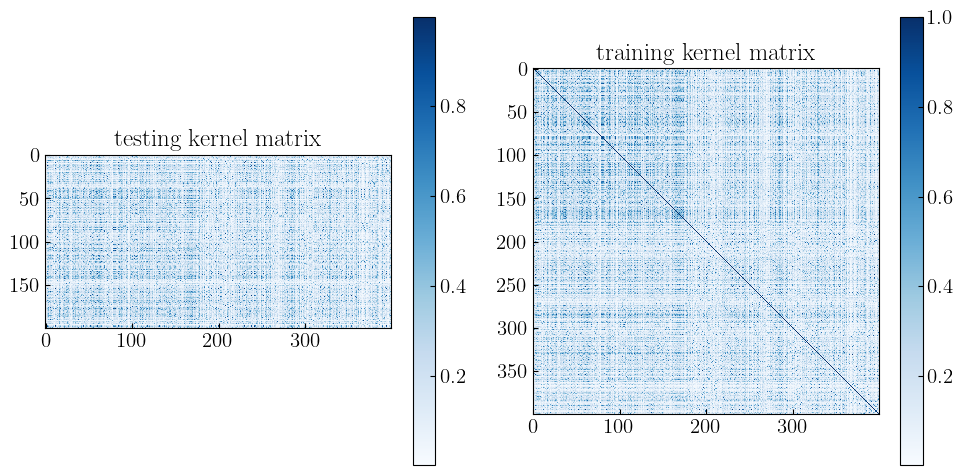

In [21]:
Q.show_kmatrix(train = _k_rbf_tr , test = _k_rbf_te,name = "")

In [22]:
c=1
clf = SVC(kernel="precomputed",C=c)
clf.fit(_k_rbf_tr, trainlabels)
y_pred = clf.predict(_k_rbf_te)
accuracy = np.mean(y_pred == testlabels)
print("C={},Accuracy:{}".format(c,accuracy))
print("\n")

C=1,Accuracy:0.855




In [23]:
C_list = [0.1, 0.5, 1.0, 5.0, 10.0]
for c in C_list:
  clf = SVC(kernel="rbf",C=c)
  clf.fit(svm_tr_data, trainlabels)
  y_pred = clf.predict(svm_te_data)
  accuracy = np.mean(y_pred == testlabels)
  print("C={},Accuracy:{}".format(c,accuracy))
  print("\n")
#C represents the penalty coefficient for misclassification,A larger value of C will make the model strictly classify all samples correctly.
#C=10 give me the best accurarcy

C=0.1,Accuracy:0.685


C=0.5,Accuracy:0.85


C=1.0,Accuracy:0.855


C=5.0,Accuracy:0.855


C=10.0,Accuracy:0.875




### quantum kernel

In [24]:
qsvm.fit(tr_kernel, trainlabels)

SVC(C=1, kernel='precomputed')

In [25]:
y_pred = qsvm.predict(te_kernel)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.84


# Geometry test

In [10]:
from scipy.linalg import sqrtm
from numpy.linalg import norm,inv

In [12]:
def Geometry_test(A,B):
    sq_B=sqrtm(B)
    return (norm(sq_B @ inv(A) @ sq_B, ord=2))**0.5

def model_complexity (k,label):
    return  label.T @ inv(k) @ label

In [43]:
import time
class progress_bar() :
    def __init__(self ,length):
        self.length = length
        self.done = "#" *20
        self.task = "-" *20
        self.clock = -1
        self.progress = -1
        self.time = time.time()
    def click(self):
        self.clock += 1
    def update(self) :
        self.click()
        p = int(20 *self.clock /self.length)
        if p != self.progress :
            print("[" ,self.done[0:p] , self.task[p:20] ,"]" , end = '\r')
            self.progress = p
    def duration(self):
        print("\ntime : "  ,(time.time() - self.time))

In [37]:
f = open('./Datasets/mini.json', 'r') 
tg = json.load(f)
f.close()
traindata = np.array(tg['train']['data'])
trainlabels = np.array(tg['train']['label'])
testdata = np.array(tg['test']['data'])
testlabels = np.array(tg['test']['label'])

In [46]:


for fn in['wine','awgn_mnist','cifar10','fashion_mnist','mini']:
    f = open(f'./Datasets/{fn}.json', 'r') 
    tg = json.load(f)
    f.close()
    traindata = np.array(tg['train']['data'])
    trainlabels = np.array(tg['train']['label'])
    testdata = np.array(tg['test']['data'])
    testlabels = np.array(tg['test']['label'])
    
    geo_dar_list=[]
    geo_dr_list=[]
    geo_dad_list=[]
    
    ac_da_list=[]
    ac_d_list=[]
    ac_r_list=[]
    
    error=[]
    
    for PCA_n in range(2,11):
        geo_dar=[]
        geo_dr=[]
        geo_dad=[]
    
        
        ac_da=[]
        ac_d=[]
        ac_r=[]
    
        t=progress_bar(15)
        for n in range(25,401,25):
    
            t.update()
            
                #Quantum
            pca=Pca(PCA_n=PCA_n,StandardizeOrNot=True,sklearnPCA=True)
            pca.fitting(traindata[:n])
            svm_tr_data=pca.transform(traindata[:n])    
            svm_te_data=pca.transform(testdata)
            svm_tr_data=pca.Renormalize_Each_Feature(svm_tr_data,Norm=np.pi/2,status="train")
            svm_te_data=pca.Renormalize_Each_Feature(svm_te_data,Norm=np.pi/2,status="test")
            
            # analog+digital
            qsvm=QSVM(task='svc')
            qsvm.default_phys_sys(atomn=PCA_n)
            tr_kernel=qsvm.get_kernel(svm_tr_data,tier=1,method="analog+digital", op="x",Error=error)
            te_kernel=qsvm.get_kernel(svm_te_data,status="test",tier=1,method="analog+digital", op="x",Error=error)
    
            # digital
            qsvmd=QSVM(task='svc')
            qsvmd.default_phys_sys(atomn=PCA_n)
            tr_kernel_d=qsvmd.get_kernel(svm_tr_data,tier=1,method="digital", op="x",Error=error)
            te_kernel_d=qsvmd.get_kernel(svm_te_data,status="test",tier=1,method="digital", op="x",Error=error)
    
            #Classic
            _k_rbf_tr = rbf_kernel(svm_tr_data,gamma=1/(10*svm_tr_data.var()))
            _k_rbf_te = rbf_kernel(svm_te_data,svm_tr_data,gamma=1/(10*svm_tr_data.var()))
    
            #Grometry
            geo_dar.append(Geometry_test(_k_rbf_tr,tr_kernel))
            geo_dr.append(Geometry_test(_k_rbf_tr,tr_kernel_d))
            geo_dad.append(Geometry_test(tr_kernel_d,tr_kernel))
    
            #test
            accuracy_da=0
            accuracy_d=0
            accuracy_r=0
            for c in [0.1,0.5,1,5,10]:
                qsvm.fit(tr_kernel, trainlabels[:n],C=c)
                y_pred = qsvm.predict(te_kernel)
                if accuracy_da < np.mean(y_pred == testlabels):accuracy_da = np.mean(y_pred == testlabels)
            
                qsvmd.fit(tr_kernel_d, trainlabels[:n],C=c)
                y_pred = qsvmd.predict(te_kernel_d)
                if accuracy_d < np.mean(y_pred == testlabels):accuracy_d = np.mean(y_pred == testlabels)
                
                svm = SVC(kernel="precomputed",C=c)
                svm.fit(_k_rbf_tr, trainlabels[:n])
                y_pred = svm.predict(_k_rbf_te)
                if accuracy_r < np.mean(y_pred == testlabels):accuracy_r = np.mean(y_pred == testlabels)
                
            ac_da.append(accuracy_da)
            ac_d.append(accuracy_d)
            ac_r.append(accuracy_r)
                
        t.duration()
        geo_dar_list.append(geo_dar)
        geo_dr_list.append(geo_dr)
        geo_dad_list.append(geo_dad)
    
        ac_da_list.append(ac_da)
        ac_d_list.append(ac_d)
        ac_r_list.append(ac_r)
        
    
    filename = f'./result/{fn}_Standardized_test.json'
    store={}
    f = open(filename , "a+")
    
    store["accuracy_da"]=ac_da_list 
    store["accuracy_d"]=ac_d_list 
    store["accuracy_r"]=ac_r_list 
    
    
    store["geometry_da"]=geo_dar_list
    store["geometry_d"]=geo_dr_list
    store["geometry_r"]=geo_dad_list
    
    
    json.dump(store , f)
    f.close()

[ ####################  ]
time :  22.19086194038391
[ ####################  ]
time :  18.772037982940674
[ ####################  ]
time :  19.64831256866455
[ ####################  ]
time :  21.051117181777954
[ ####################  ]
time :  23.20577836036682
[ ####################  ]
time :  28.99600386619568
[ ####################  ]
time :  41.7587354183197
[ ####################  ]
time :  87.07101583480835
[ ####################  ]
time :  297.2617287635803
[ ####################  ]
time :  18.005311250686646
[ ####################  ]
time :  20.035943508148193
[ ####################  ]
time :  18.65795350074768
[ ####################  ]
time :  19.45412254333496
[ ####################  ]
time :  25.464662551879883
[ ####################  ]
time :  29.053016424179077
[ ####################  ]
time :  42.60735368728638
[ ####################  ]
time :  87.15388035774231
[ ####################  ]
time :  312.0786974430084
[ ####################  ]
time :  18.204233407974243
[ ####

In [20]:

for 

geo_dar_list=[]
geo_dr_list=[]
geo_dad_list=[]

ac_da_list=[]
ac_d_list=[]
ac_r_list=[]

error=[0.005,0.01,0.1]

for PCA_n in range(2,11):
    geo_dar=[]
    geo_dr=[]
    geo_dad=[]

    
    ac_da=[]
    ac_d=[]
    ac_r=[]
    t=progress_bar(16)
    for n in range(25,401,25):
        t.update()
        geo_dar_sample=[]
        geo_dr_sample=[]
        geo_dad_sample=[]
        ac_da＿sample=[]
        ac_d＿sample=[]
        ac_r＿sample=[]
        for _ in range(3):
            #Quantum
            pca=Pca(PCA_n=PCA_n,StandardizeOrNot=False,sklearnPCA=True)
            pca.fitting(traindata[:n])
            svm_tr_data=pca.transform(traindata[:n])    
            svm_te_data=pca.transform(testdata)
            svm_tr_data=pca.Renormalize_Each_Feature(svm_tr_data,Norm=np.pi/2,status="train")
            svm_te_data=pca.Renormalize_Each_Feature(svm_te_data,Norm=np.pi/2,status="train")
            
            # analog+digital
            qsvm=QSVM(task='svc')
            qsvm.default_phys_sys(atomn=PCA_n)
            tr_kernel=qsvm.get_kernel(svm_tr_data,tier=1,method="analog+digital", op="x",Error=error)
            te_kernel=qsvm.get_kernel(svm_te_data,status="test",tier=1,method="analog+digital", op="x",Error=error)
    
            # digital
            qsvmd=QSVM(task='svc')
            qsvmd.default_phys_sys(atomn=PCA_n)
            tr_kernel_d=qsvmd.get_kernel(svm_tr_data,tier=1,method="digital", op="x",Error=error)
            te_kernel_d=qsvmd.get_kernel(svm_te_data,status="test",tier=1,method="digital", op="x",Error=error)
    
            #Classic
            _k_rbf_tr = rbf_kernel(svm_tr_data,gamma=1/(10*svm_tr_data.var()))
            _k_rbf_te = rbf_kernel(svm_te_data,svm_tr_data,gamma=1/(10*svm_tr_data.var()))
    
            #Grometry
            geo_dar_sample.append(Geometry_test(_k_rbf_tr,tr_kernel))
            geo_dr_sample.append(Geometry_test(_k_rbf_tr,tr_kernel_d))
            geo_dad_sample.append(Geometry_test(tr_kernel_d,tr_kernel))
    
            #test
            accuracy_da=0
            accuracy_d=0
            accuracy_r=0
            for c in [0.1,0.5,1,5,10]:
                qsvm.fit(tr_kernel, trainlabels[:n],C=1)
                y_pred = qsvm.predict(te_kernel)
                if accuracy_da < np.mean(y_pred == testlabels):accuracy_da = np.mean(y_pred == testlabels)

        
                qsvmd.fit(tr_kernel_d, trainlabels[:n],C=0.1)
                y_pred = qsvmd.predict(te_kernel_d)
                if accuracy_d < np.mean(y_pred == testlabels):accuracy_d = np.mean(y_pred == testlabels)

                
                svm = SVC(kernel="precomputed",C=0.1)
                svm.fit(_k_rbf_tr, trainlabels[:n])
                y_pred = svm.predict(_k_rbf_te)
                if accuracy_r < np.mean(y_pred == testlabels):accuracy_r = np.mean(y_pred == testlabels)
                
            ac_da_sample.append(accuracy_da)
            ac_d_sample.append(accuracy_d)
            ac_r_sample.append(accuracy_r)
            
        geo_dar.append(geo_dar_sample)
        geo_dr.append(geo_dr_sample)
        geo_dad.append(geo_dad_sample)
    
        ac_da.append(ac_da_sample)
        ac_d.append(ac_d_sample)
        ac_r.append(ac_r_sample)
        
    t.duration()
    geo_dar_list.append(geo_dar)
    geo_dr_list.append(geo_dr)
    geo_dad_list.append(geo_dad)

    ac_da_list.append(ac_da)
    ac_d_list.append(ac_d)
    ac_r_list.append(ac_r)
    

filename = './result/wine_test_error.json'
store={}
f = open(filename , "a+")

store["accuracy_da"]=geo_dar_list
store["accuracy_d"]=geo_dr_list
store["accuracy_r"]=geo_dad_list


store["geometry_da"]=ac_da_list
store["geometry_d"]=ac_d_list
store["geometry_r"]=ac_r_list


json.dump(store , f)
f.close()

NameError: name 'ac_da_sample' is not defined

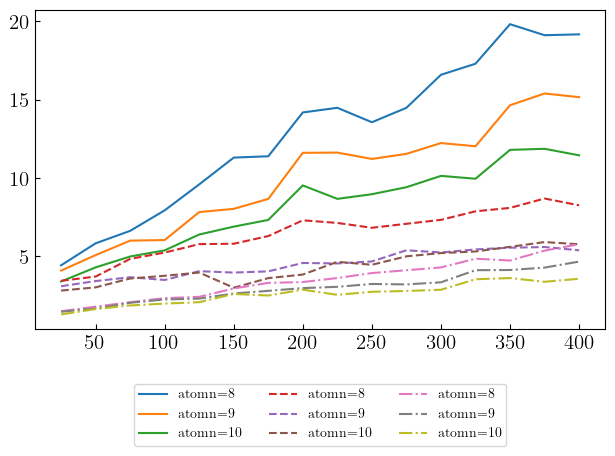

In [48]:
filename = './result/fashion_mnist_NoStandardized_test.json'
start=6
end=9


f = open(filename , "r")
story=json.load(f)
geo_dar_list=story["accuracy_da"]
geo_dr_list=story["accuracy_d"]
geo_dad_list=story["accuracy_r"]


ac_da_list=story["geometry_da"]
ac_d_list=story["geometry_d"]
ac_r_list=story["geometry_r"]

for i,ll in enumerate(ac_da_list[start:end],1):
    plt.plot( range(25,401,25),ll,label=f"atomn={i+start+1}")
for i,ll in enumerate(ac_d_list[start:end],1):
    plt.plot( range(25,401,25),ll,label=f"atomn={i+start+1}",ls="--")
for i,ll in enumerate(ac_r_list[start:end],1):
    plt.plot( range(25,401,25),ll,label=f"atomn={i+start+1}",ls="-.")
plt.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

f.close()

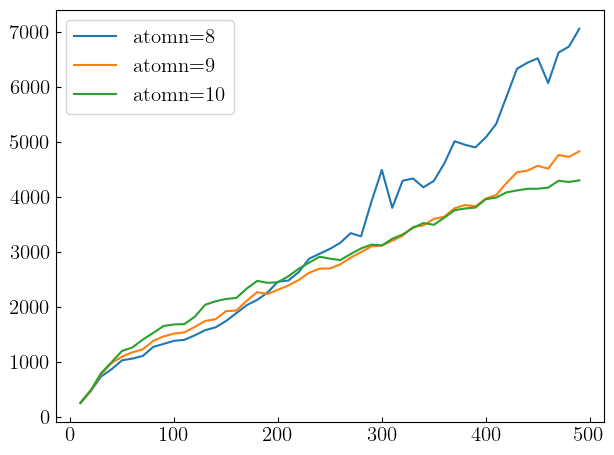

In [59]:
start=7
for i,ll in enumerate(s[start:],1):
    plt.plot( range(10,500,10),ll,label=f"atomn={i+start}")

plt.legend()